<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_10_manifold_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connections Visualization

In [0]:
#@title Pairwise distances
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_hello(N=1000, rseed=42):
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

import numpy as np

# arrange "hello" in non-linear, S-shaped way
def make_hello_s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T
XS = make_hello_s_curve(X)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
colors = ['rgb(' + np.array2string(c[:-1], formatter={'float_kind':lambda x:  "%.0f" % (x * 255)}, separator=',')[1:-1] + ')' for c in colorize['cmap'](0.255*colorize['c'])]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2], 
                           mode='markers', name='datapoints (LEFT)', 
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=1)
fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2], 
                           mode='markers', name='datapoints (RIGHT)', 
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=2)

# construct lines for LLE
from sklearn.neighbors import NearestNeighbors

N_neighbours = 100

rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
nbrs = NearestNeighbors(n_neighbors=N_neighbours, radius=100.0).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = []
for i in range(100):
  for j in nbrs[i]:
    lines_LLE = lines_LLE + [XS[ind[i]], XS[j], np.array([None, None, None])]
lines_LLE = np.array(lines_LLE)

fig.add_trace(go.Scatter3d(
    x=lines_LLE[:, 0],
    y=lines_LLE[:, 1],
    z=lines_LLE[:, 2],
    mode='lines', opacity=0.2,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='LLE connections'
), row=1, col=1)

# construct lines for MDS
lines_MDS = []
for i in ind[:100]:
  for j in ind[100:200]:
    lines_MDS = lines_MDS + [XS[i], XS[j], np.array([None, None, None])]
lines_MDS = np.array(lines_MDS)

fig.add_trace(go.Scatter3d(
    x=lines_MDS[:, 0],
    y=lines_MDS[:, 1],
    z=lines_MDS[:, 2],
    mode='lines', opacity=0.1,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='MDS connections'
), row=1, col=2)

fig.show()


#Sklearn manifold learning methods

Use the following example to getintuition on how manifold learning works.
* Try different parameters for MDS and Isomap. Notice that `n_neighbours` **significantly** changes the result. Try different values to see the effect
* Implement your own surface modifying the `custom(X)` function. As an example roulette is given.

In [0]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

def linear_embedding(datapoints):
  model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
  return model.fit_transform(datapoints)

def multidim_scaling(datapoints):
  model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
  D = pairwise_distances(X)
  return model.fit_transform(D)

from sklearn.manifold import Isomap
def isomap(datapoints):
  model = Isomap(n_components = 2, n_neighbors=200)
  return model.fit_transform(datapoints)


def custom(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  roulette = np.array([[(2 + p[0]) * np.cos(2 * p[0]), (2 + p[0]) * np.sin(2 * p[0]), 2.0 * p[1]] for p in params])
  return roulette 

In [7]:
#@title Explore manifold learning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns

def make_hello(N=1000, rseed=42):
  import seaborn as sns; sns.set();
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
colors = ['rgb(' + np.array2string(c[:-1], formatter={'float_kind':lambda x:  "%.0f" % (x * 255)}, separator=',')[1:-1] + ')' for c in colorize['cmap'](0.255*colorize['c'])]


def unwind_manifold(datapoints, method):
  methods = {'lle': linear_embedding, 'mds': multidim_scaling, 'isomap': isomap}
  return methods[method](datapoints)
        
def s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T

def mobius(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  mobius = np.array([[(1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.cos(p[0]), (1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.sin(p[0]), p[1]/2.0 * np.sin(p[0]/2)] for p in params])
  return mobius

def cylinder(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  cylinder = np.array([[2.0 * np.cos(p[0]), 2.0 * np.sin(p[0]), p[1]] for p in params])
  return cylinder

def helicoid(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  helicoid = np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[0]] for p in params])
  return helicoid

def cone(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  cone = np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[1]] for p in params])
  return cone  

def transform_to_3d(x, manifold):
  funcs = {'s_curve': s_curve, 'mobius': mobius, 'cylinder': cylinder, 
           'helicoid': helicoid, 'cone': cone, 'custom': custom}
  return funcs[manifold](x)

def plot_unwinded(x):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.scatter(x[:, 0], x[:, 1], **colorize)
  #ax.set_ylim(0.15, -0.15);
  plt.close(fig)
  return fig


import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json
from IPython.display import display, clear_output

def invoke(manifold, method):  
  man = transform_to_3d(X, manifold)
  unw = unwind_manifold(man, method)
  figr = plot_unwinded(unw)
  image_base64 = figure_to_base64(figr)

  #x_ = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), num=10)
  #y_ = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), num=10)
  #xx, yy = np.meshgrid(x_, y_)
  #x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
  #Y = transform_to_3d(x_vec, manifold)[:,2].reshape((x_.shape[0],y_.shape[0]))
  return IPython.display.JSON({'image': image_base64, 
  #                             'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': Y.tolist(),
                               's_x': man[:, 0].tolist(), 's_y': man[:, 1].tolist(), 's_z': man[:, 2].tolist(), 's_c': colors})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
      }
    }
    
    var timer

   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
     var layout = {
          title: 'Manifold',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
    debug_txt = 'before plot';
     Plotly.newPlot(cell_for_plot, data, layout);
     debug_txt = 'go';
   }

   function plot_scatter(s_x, s_y, s_z, colors)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             color: colors,
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
     var layout = {
          title: 'Manifold',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
    Plotly.newPlot(cell_for_plot, data, layout);
    //Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      var e = document.getElementById("select_kernel");
      var ker_name = e.options[e.selectedIndex].value;
      var e1 = document.getElementById("select_metric");
      var metric_name = e1.options[e1.selectedIndex].value;
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [ker_name, metric_name], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      //cell_for_plot = document.getElementById('for_plotly_plot');
      
      //plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z, params.s_c);
      
    }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   Manifold:<br>
   <select id="select_kernel">
       <option value="mobius">Mobius strip</option>
       <option value="s_curve">S-shaped sheet</option>
       <option value="cylinder">Cylinder</option>
       <option value="helicoid">Helicoid</option>
       <option value="cone">Cone</option>
       <option value="custom">Custom Surface</option>
   </select>
   <br>
   Method:
   <br>
   <select id="select_metric">
       <option value="lle">Locally Linear Embedding (LLE)</option>
       <option value="mds">Multidimensional Scaling (MDS)</option>
       <option value="isomap">Isomap (Iso)</option>
   </select>
   <br><br>
    <button type="button" onclick="calculate();">
      Unfold
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

#MNIST and manifold learning

* Load MNIST dataset

In [0]:
from sklearn.datasets import load_digits
import numpy as np
digits = load_digits()
data, target = digits.data, digits.target

* Complete the following functions so that they reduce dimensions of the `data` to 3. The shape of the result is expected to be `(1797, 3)`.

In [0]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

def projected_isomap():
  model = Isomap(n_components=3, n_neighbors=30)
  return model.fit_transform(data)

def projected_PCA():
  pca = PCA(n_components=3)
  return pca.fit_transform(data)

* Start the visualization code to see the result

In [6]:
#@title Visualization
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[int(d)] for d in digits.target]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

iso_proj = projected_isomap()
fig.add_trace(go.Scatter3d(x=iso_proj[:, 0], y=iso_proj[:, 1], z=iso_proj[:, 2], 
                           mode='markers', 
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

pca_proj = projected_PCA()
fig.add_trace(go.Scatter3d(x=pca_proj[:, 0], y=pca_proj[:, 1], z=pca_proj[:, 2], 
                           mode='markers', 
                           marker=dict(size=4, color=colors)),
              row=1, col=2)

fig.update_layout(width=1200, height=600, autosize=False, 
                  title_text="3-component Isomap (left) and PCA (right) for MNIST",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)
      
fig.show()

(1797, 3)


* split dataset into `train` and `test`
* Create $3$ models:
   - any classifier (simple)
   - PCA + any classifier
   - Isomap + any classifier
* Train models
* Get predicted labels from all models

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=False)

model_simple = Pipeline([('SVM', svm.SVC(kernel='linear', C=1E2))])
model_isomap = Pipeline([('Isomap', Isomap(n_components=2, n_neighbors=7)), ('SVM', svm.SVC(kernel='linear', C=1E2))])
model_pca    = Pipeline([('PCA', PCA(n_components=30)), ('SVM', svm.SVC(kernel='linear', C=1E2))])

model_simple.fit(X_train, y_train)
model_isomap.fit(X_train, y_train)
model_pca.fit(X_train, y_train)

l_simple = model_simple.predict(X_test)
l_isomap = model_isomap.predict(X_test)
l_pca = model_pca.predict(X_test)

def get_results():
  return y_test, ['Simple model', 'isomap', 'pca'], [l_simple, l_isomap, l_pca]

* Run visualization code to see confusion matrices.

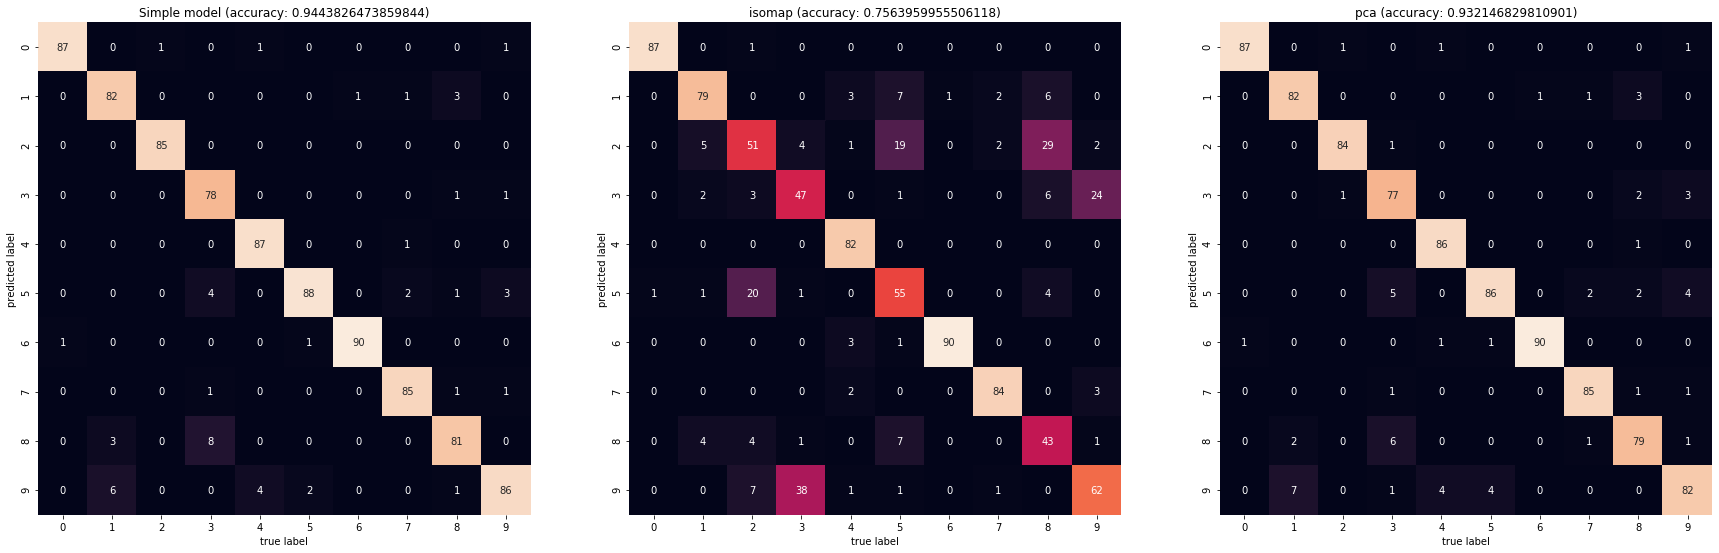

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

trg, names, labels = get_results()
num_plots = len(names)
fig = plt.figure(figsize=(10 * num_plots, 10))

for idx in range(num_plots):
  plt.subplot(1, num_plots, 1 + idx)
  mat = confusion_matrix(trg, labels[idx])
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[i for i in range(10)],
            yticklabels=[i for i in range(10)])
  plt.ylim(10.0, 0.0)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  
  plt.title(names[idx] + " (accuracy: " + str(accuracy_score(trg, labels[idx])) + ")")